In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



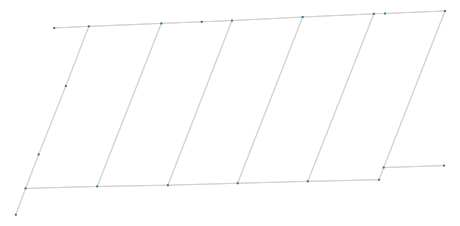

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/abd8b76958a44d7ebb8932468d72c6ab-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/abd8b76958a44d7ebb8932468d72c6ab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 387 COLUMNS
At line 3352 RHS
At line 3735 BOUNDS
At line 4135 ENDATA
Problem MODEL has 382 rows, 399 columns and 1786 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1428.49 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 342 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 342 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 342 strengthened rows, 0 substitutions
Cg

s was tried 19 times and created 319 cuts of which 0 were active after adding rounds of cuts (0.070 seconds)
ZeroHalf was tried 19 times and created 26 cuts of which 0 were active after adding rounds of cuts (0.046 seconds)

Result - Optimal solution found

Objective value:                1734.30000000
Enumerated nodes:               0
Total iterations:               631
Time (CPU seconds):             1.95
Time (Wallclock seconds):       2.06

Option for printingOptions changed from normal to all
Total time (CPU seconds):       1.96   (Wallclock seconds):       2.07



In [25]:

#Creating a bounding box
north, south, east, west = 43.173480,43.176077,-77.577596,-77.570343    
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 11
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(11)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


In [26]:
path1=pathlist

In [6]:
#finalroutes = []

In [10]:
#bb = []
#bb1 = [-77.566137,43.174168,-77.561975,43.176296]
#bb2 = [-77.565536,43.169786,-77.559657,43.171602]
#b.append(bb1)
#b.append(bb2)

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



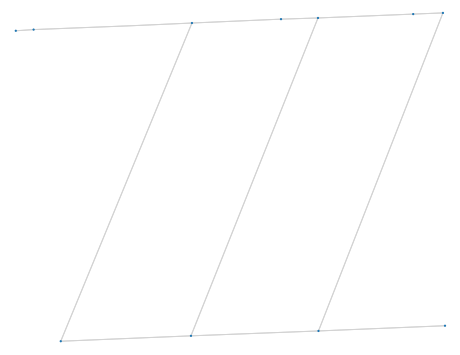

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/f4049ab55d984a61ab76aaebafd0a626-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/f4049ab55d984a61ab76aaebafd0a626-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 117 COLUMNS
At line 958 RHS
At line 1071 BOUNDS
At line 1192 ENDATA
Problem MODEL has 112 rows, 120 columns and 490 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 630.073 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 90 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 90 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 90 strengthened rows, 0 substitutions
Cgl0003

tions 17
Cbc0038I Pass  68: suminf.    4.18898 (12) obj. 1061.7 iterations 20
Cbc0038I Pass  69: suminf.    2.87824 (10) obj. 1061.7 iterations 29
Cbc0038I Pass  70: suminf.    1.67118 (10) obj. 1061.7 iterations 38
Cbc0038I No solution found this major pass
Cbc0038I Before mini branch and bound, 50 integers at bound fixed and 0 continuous
Cbc0038I Full problem 112 rows 120 columns, reduced to 112 rows 70 columns
Cbc0038I Mini branch and bound did not improve solution (0.51 seconds)
Cbc0038I After 0.51 seconds - Feasibility pump exiting with objective of 1188.8 - took 0.39 seconds
Cbc0012I Integer solution of 1188.8 found by feasibility pump after 0 iterations and 0 nodes (0.51 seconds)
Cbc0038I Full problem 112 rows 120 columns, reduced to 50 rows 13 columns
Cbc0031I 12 added rows had average density of 25.5
Cbc0013I At root node, 12 cuts changed objective from 634.53818 to 954.6 in 8 passes
Cbc0014I Cut generator 0 (Probing) - 38 row cuts average 2.7 elements, 0 column cuts (0 active

In [14]:

#Creating a bounding box
north, south, east, west = 43.174168,43.176296,-77.566137,-77.561975   
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 4
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(start1)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)



In [15]:
path2=pathlist

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



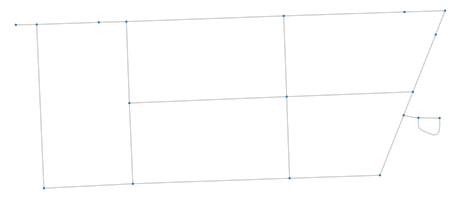

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/b46b2fc14ff7438693cdb159cafd6b32-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0f/0wx77bhd2sl15rhs858yxhtc0000gn/T/b46b2fc14ff7438693cdb159cafd6b32-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 313 COLUMNS
At line 2694 RHS
At line 3003 BOUNDS
At line 3327 ENDATA
Problem MODEL has 308 rows, 323 columns and 1428 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1050.59 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 272 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 272 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 272 strengthened rows, 0 substitutions
Cg

s
Cbc0004I Integer solution of 1412.1 found after 54241 iterations and 1203 nodes (18.07 seconds)
Cbc0038I Full problem 308 rows 323 columns, reduced to 266 rows 21 columns - 2 fixed gives 253, 18 - still too large
Cbc0010I After 2000 nodes, 3 on tree, 1412.1 best solution, best possible 1254.0997 (25.71 seconds)
Cbc0004I Integer solution of 1411.4 found after 105694 iterations and 2191 nodes (28.21 seconds)
Cbc0038I Full problem 308 rows 323 columns, reduced to 280 rows 31 columns - 1 fixed gives 278, 28 - still too large
Cbc0010I After 3000 nodes, 5 on tree, 1411.4 best solution, best possible 1254.0997 (37.08 seconds)
Cbc0001I Search completed - best objective 1411.4, took 160264 iterations and 3035 nodes (37.74 seconds)
Cbc0032I Strong branching done 3878 times (72445 iterations), fathomed 76 nodes and fixed 201 variables
Cbc0035I Maximum depth 27, 25173 variables fixed on reduced cost
Cuts at root node changed objective from 1051.18 to 1254.1
Probing was tried 5265 times and creat

In [16]:

#Creating a bounding box
north, south, east, west = 43.169786,43.171602,-77.565536,-77.559657  
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
#G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 11
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(11)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines       
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)




In [30]:
path3=pathlist

In [29]:
mainpath=path1+path2+path3

In [31]:
path1

[212696984.0,
 212903621,
 212903621.0,
 212696984,
 212633053.0,
 212633053.0,
 212696988,
 212696988.0,
 212696990,
 212696990.0,
 212696993,
 212696993.0,
 212696996,
 212696996.0,
 212697004,
 212697011.0,
 212697011.0,
 212697004,
 212697004.0,
 212643444,
 212643444.0,
 212643441,
 212643441.0,
 212643439,
 212643439.0,
 212643436,
 212643436.0,
 212643433,
 212643433.0,
 7085465650,
 7085465650.0,
 212633055,
 212633055.0,
 212643431,
 212643427.0,
 212643427.0,
 212643431,
 212643431.0,
 212626130,
 212626130.0,
 212670532,
 212670532.0,
 212696984]

In [32]:
path2

[212643473.0,
 212643476,
 212643476.0,
 212632105,
 212632105.0,
 212643478,
 212643478.0,
 212643481,
 212643481.0,
 212697035,
 212697039.0,
 212697039.0,
 212697035,
 212697035.0,
 212632102,
 212632102.0,
 212697032,
 212697032.0,
 212643473,
 212643469,
 212643467.0,
 212643467.0,
 212643469,
 212643469.0,
 212643473]

In [33]:
path3

[212696984.0,
 212903621,
 212903621.0,
 212696984,
 212633053.0,
 212633053.0,
 212696988,
 212696988.0,
 212696990,
 212696990.0,
 212696993,
 212696993.0,
 212696996,
 212696996.0,
 212697004,
 212697011.0,
 212697011.0,
 212697004,
 212697004.0,
 212643444,
 212643444.0,
 212643441,
 212643441.0,
 212643439,
 212643439.0,
 212643436,
 212643436.0,
 212643433,
 212643433.0,
 7085465650,
 7085465650.0,
 212633055,
 212633055.0,
 212643431,
 212643427.0,
 212643427.0,
 212643431,
 212643431.0,
 212626130,
 212626130.0,
 212670532,
 212670532.0,
 212696984]

In [36]:
G = ox.graph_from_place('Rochester, NY, USA', network_type='drive')

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/rochelleallan/anaconda3/envs/ox/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



In [37]:
path12 = nx.shortest_path(G, 212696984,212643473, weight='travel_time')

In [38]:
path23 = nx.shortest_path(G, 212643473,212696984, weight='travel_time')

In [39]:


path12

[212696984,
 212633053,
 212633055,
 212643431,
 212731609,
 212642331,
 212731612,
 212881997,
 212870974,
 212643467,
 212643469,
 212643473]

In [40]:
path12[1:-1]

[212633053,
 212633055,
 212643431,
 212731609,
 212642331,
 212731612,
 212881997,
 212870974,
 212643467,
 212643469]

In [43]:
path23

[212643473,
 212643469,
 212643467,
 212870974,
 212881997,
 212731612,
 212642331,
 212731609,
 212643431,
 212633055,
 212633053,
 212696984]

In [44]:
path23[1:-1]

[212643469,
 212643467,
 212870974,
 212881997,
 212731612,
 212642331,
 212731609,
 212643431,
 212633055,
 212633053]

In [45]:
mainroute = path1+path12[1:-1]+path2+path23[1:-1]+path3

In [46]:
mainroute1 = []
for i in mainroute:
    mainroute1.append(int(i))

In [53]:
mainroute1 = []
for i in mainroute:
    if i != 7085465650:
        mainroute1.append(int(i))
    

In [55]:
lines = node_list_to_path2(G, mainroute1)

In [56]:
long2 = []
lat2 = []

In [57]:
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])

In [58]:
plot_path(lat2, long2, origin_point, destination_point)

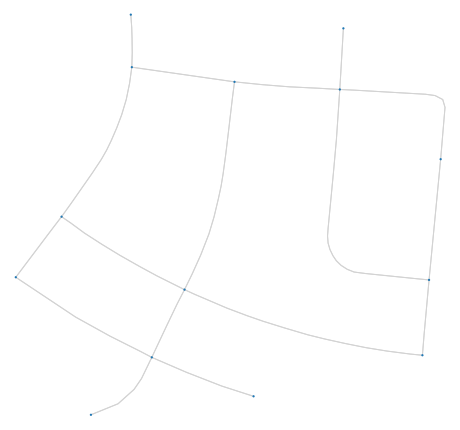

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [20]:
east, north, west, south = -78.809105,35.573096,-78.804878,35.576726
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

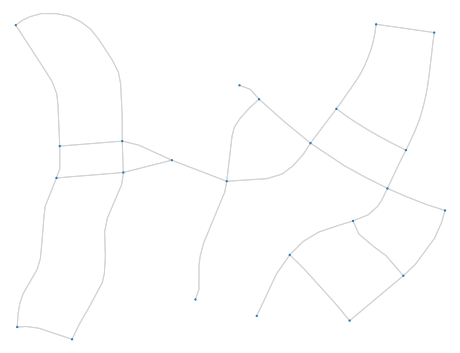

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [69]:
east, north, west, south =-78.814085,35.571632,-78.806876,35.576170
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

In [24]:
list1 = G.nodes

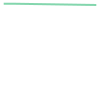

In [41]:
start_node=list1[9] 
end_node=list1[10]
# Getting the edge connecting these nodes and storing it as a list in z to maintain the data structure of G.edges 
z = []  
for i in list(G.edges(data=True)):
     if (i[0]==start_node) & (i[1]==end_node):
        z.append(i)
 
z[0][2]['geometry']

In [46]:
routes[0][1][0]

5

In [70]:
-78.813892,35.571852,-78.811940,35.576372

(-78.813892, 35.571852, -78.81194, 35.576372)

In [72]:
for i in pathlist1:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
plot_path(lat1, long1, origin_point, destination_point)

In [74]:
pathlist2 = pathlist1

In [77]:
pathlist2

[1143194636.0,
 1144843368,
 1144854610,
 1144854612,
 1144854615,
 1143194684,
 1143194662,
 1143194645,
 1144837503,
 1144881870,
 1278913065,
 1278912834,
 1278913005,
 3921468242,
 1278912845,
 3921468251,
 1278912990,
 1278912976,
 1144881817,
 1144881843,
 1144881840,
 1143133738,
 1278913196,
 1278912861,
 1143133742,
 1143194636.0]

In [80]:
 edge_nodes = list(zip(pathlist2[:-1], pathlist2[1:]))

In [81]:
edge_nodes

[(1143194636.0, 1144843368),
 (1144843368, 1144854610),
 (1144854610, 1144854612),
 (1144854612, 1144854615),
 (1144854615, 1143194684),
 (1143194684, 1143194662),
 (1143194662, 1143194645),
 (1143194645, 1144837503),
 (1144837503, 1144881870),
 (1144881870, 1278913065),
 (1278913065, 1278912834),
 (1278912834, 1278913005),
 (1278913005, 3921468242),
 (3921468242, 1278912845),
 (1278912845, 3921468251),
 (3921468251, 1278912990),
 (1278912990, 1278912976),
 (1278912976, 1144881817),
 (1144881817, 1144881843),
 (1144881843, 1144881840),
 (1144881840, 1143133738),
 (1143133738, 1278913196),
 (1278913196, 1278912861),
 (1278912861, 1143133742),
 (1143133742, 1143194636.0)]

In [114]:
for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        if(G.get_edge_data(u, v) == True):
            data = min(G.get_edge_data(u, v).values(), 
                   key=lambda x: x['length']) 
        else:
            data=Null

In [87]:
data

{'osmid': 98958623,
 'name': 'Willow Bay Drive',
 'highway': 'residential',
 'maxspeed': '25 mph',
 'oneway': False,
 'length': 101.713}

In [118]:
G.get_edge_data(1144881817, 1144881843)

In [120]:
G.get_edge_data(1278912861, 1143133742).values()

dict_values([{'osmid': 112548305, 'name': 'Lawson Cypress Lane', 'highway': 'residential', 'oneway': False, 'length': 177.062, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000268C5CC7940>}])

In [218]:
def node_list_to_path1(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    

In [167]:
type(edge_nodes[0])

tuple

In [130]:
pathlist2

[1143194636.0,
 1144843368,
 1144854610,
 1144854612,
 1144854615,
 1143194684,
 1143194662,
 1143194645,
 1144837503,
 1144881870,
 1278913065,
 1278912834,
 1278913005,
 3921468242,
 1278912845,
 3921468251,
 1278912990,
 1278912976,
 1144881817,
 1144881843,
 1144881840,
 1143133738,
 1278913196,
 1278912861,
 1143133742,
 1143194636.0]

In [129]:
G.nodes(1144854615)

NodeDataView({1143133738: None, 1143133742: None, 1143194636: None, 1143194645: None, 1143194662: None, 1143194684: None, 1144837503: None, 1144843368: None, 1144854610: None, 1144854612: None, 1144881817: None, 1144881840: None, 1144881843: None, 1144881870: None, 1278912834: None, 1278912845: None, 1278912861: None, 1278912976: None, 1278912990: None, 1278913005: None, 1278913065: None, 1278913196: None, 3921468242: None, 3921468251: None}, data=1144854615)

In [131]:
path1 = nx.shortest_path(G,1144881817, 1144881843, weight='travel_time')

In [132]:
path1

[1144881817, 1144881870, 1144881843]

In [133]:
#----------------

In [134]:
path1[1:-1]

[1144881870]

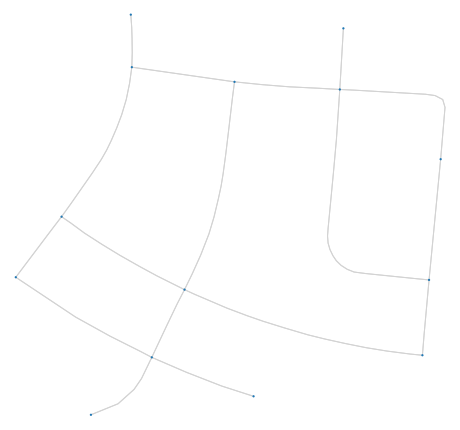

C:\Users\sawag\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning:

Mean of empty slice.

C:\Users\sawag\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning:

invalid value encountered in double_scalars



In [149]:

#Creating a bounding box
east, north, west, south = -78.809105,35.573096,-78.804878,35.576726  
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path1(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        if(G.get_edge_data(u, v) == True):
            data = min(G.get_edge_data(u, v).values(), 
                   key=lambda x: x['length'])
            # if it has a geometry attribute
            if 'geometry' in data:
            # add them to the list of lines to plot
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)
        
        
            
    return lines        
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1[1:-1]
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist1)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path1(G, pathlist1)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist1:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


In [150]:
pathlist2 = pathlist1

In [152]:
pathlist2 = pathlist2[:-1]

In [153]:
pathlist2

[1143194636.0,
 1144843368,
 1144854610,
 1144854612,
 1144854615,
 1143194684,
 1143194662,
 1143194645,
 1144837503,
 1144881870,
 1278913065,
 1278912834,
 1278913005,
 3921468242,
 1278912845,
 3921468251,
 1278912990,
 1278912976,
 1144881817,
 1144881843,
 1144881840,
 1143133738,
 1278913196,
 1278912861,
 1143133742,
 1143194636.0]

In [219]:
lines = node_list_to_path1(G, pathlist2)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])

In [220]:
plot_path(lat2, long2, origin_point, destination_point)

In [188]:
len(edge_nodes)

25

In [176]:
len(edge_nodes)

25

In [183]:
type(edge_nodes[0])

tuple

In [184]:
edge_nodes[0]

(1143194636.0, 1144843368)

In [214]:
len(newlist)

20

In [200]:
b = edge_nodes

In [201]:
b

[(1143194636.0, 1144843368),
 (1144843368, 1144854610),
 (1144854610, 1144854612),
 (1144854612, 1144854615),
 (1144854615, 1143194684),
 (1143194684, 1143194662),
 (1143194662, 1143194645),
 (1143194645, 1144837503),
 (1144837503, 1144881870),
 (1144881870, 1278913065),
 (1278913065, 1278912834),
 (1278912834, 1278913005),
 (1278913005, 3921468242),
 (3921468242, 1278912845),
 (1278912845, 3921468251),
 (3921468251, 1278912990),
 (1278912990, 1278912976),
 (1278912976, 1144881817),
 (1144881817, 1144881843),
 (1144881843, 1144881840),
 (1144881840, 1143133738),
 (1143133738, 1278913196),
 (1278913196, 1278912861),
 (1278912861, 1143133742),
 (1143133742, 1143194636.0)]

In [209]:
newlist=[]
for u, v in b:
    #print(G.get_edge_data(u, v))
    if(G.get_edge_data(u, v)):
        #print('Hi')
        newlist.append((u,v))
print(newlist)
print(len(newlist))

Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
Hi
[(1143194636.0, 1144843368), (1144843368, 1144854610), (1144854610, 1144854612), (1144854612, 1144854615), (1144854615, 1143194684), (1143194684, 1143194662), (1143194662, 1143194645), (1144837503, 1144881870), (1144881870, 1278913065), (1278913065, 1278912834), (1278912834, 1278913005), (1278913005, 3921468242), (1278912845, 3921468251), (3921468251, 1278912990), (1278912990, 1278912976), (1144881843, 1144881840), (1143133738, 1278913196), (1278913196, 1278912861), (1278912861, 1143133742), (1143133742, 1143194636.0)]
20


In [221]:
newlist

[(1143194636.0, 1144843368),
 (1144843368, 1144854610),
 (1144854610, 1144854612),
 (1144854612, 1144854615),
 (1144854615, 1143194684),
 (1143194684, 1143194662),
 (1143194662, 1143194645),
 (1144837503, 1144881870),
 (1144881870, 1278913065),
 (1278913065, 1278912834),
 (1278912834, 1278913005),
 (1278913005, 3921468242),
 (1278912845, 3921468251),
 (3921468251, 1278912990),
 (1278912990, 1278912976),
 (1144881843, 1144881840),
 (1143133738, 1278913196),
 (1278913196, 1278912861),
 (1278912861, 1143133742),
 (1143133742, 1143194636.0)]

In [222]:
edge_nodes

[(1143194636.0, 1144843368),
 (1144843368, 1144854610),
 (1144854610, 1144854612),
 (1144854612, 1144854615),
 (1144854615, 1143194684),
 (1143194684, 1143194662),
 (1143194662, 1143194645),
 (1143194645, 1144837503),
 (1144837503, 1144881870),
 (1144881870, 1278913065),
 (1278913065, 1278912834),
 (1278912834, 1278913005),
 (1278913005, 3921468242),
 (3921468242, 1278912845),
 (1278912845, 3921468251),
 (3921468251, 1278912990),
 (1278912990, 1278912976),
 (1278912976, 1144881817),
 (1144881817, 1144881843),
 (1144881843, 1144881840),
 (1144881840, 1143133738),
 (1143133738, 1278913196),
 (1278913196, 1278912861),
 (1278912861, 1143133742),
 (1143133742, 1143194636.0)]

In [223]:
path1 = nx.shortest_path(G,1143194645, 1144837503, weight='travel_time')

In [224]:
path1

[1143194645, 1143194636, 1144837503]

In [225]:
path2 = list(zip(path1[:-1], path1[1:]))

In [227]:
path2

[(1143194645, 1143194636), (1143194636, 1144837503)]

In [248]:
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    

In [237]:
for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2

Hi
Hi
Hi
Hi
Hi


In [254]:
lines = node_list_to_path2(G, pathlist2)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])

In [255]:
plot_path(lat2, long2, origin_point, destination_point)

In [253]:
len(newlist)

20

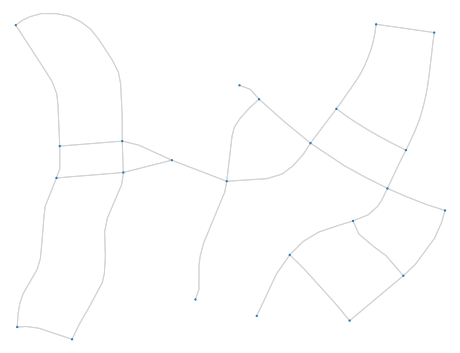

In [256]:

#Creating a bounding box
east, north, west, south = -78.814085,35.571632,-78.806876,35.576170  
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1[1:-1]
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist1)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist1)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist1:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


In [258]:
edge_nodes

[(1143194636.0, 1144843368),
 (1144843368, 1144854610),
 (1144854610, 1144854612),
 (1144854612, 1144854615),
 (1144854615, 1143194684),
 (1143194684, 1143194662),
 (1143194662, 1143194645),
 (1143194645, 1144837503),
 (1144837503, 1144881870),
 (1144881870, 1278913065),
 (1278913065, 1278912834),
 (1278912834, 1278913005),
 (1278913005, 3921468242),
 (3921468242, 1278912845),
 (1278912845, 3921468251),
 (3921468251, 1278912990),
 (1278912990, 1278912976),
 (1278912976, 1144881817),
 (1144881817, 1144881843),
 (1144881843, 1144881840),
 (1144881840, 1143133738),
 (1143133738, 1278913196),
 (1278913196, 1278912861),
 (1278912861, 1143133742),
 (1143133742, 1143194636.0)]

In [259]:
mainroute1

[1278913066,
 1278913077,
 1278913206,
 1278912898,
 1278913064,
 1278913223,
 1278913066,
 1278912898,
 1278913064,
 1278913020,
 1143194684,
 1143194662,
 1143194645,
 1143194636,
 1144843368,
 1144854610,
 1144854612,
 1144854615,
 1143194684,
 1143194662]

In [261]:
lines = node_list_to_path2(G, mainroute1)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
plot_path(lat2, long2, origin_point, destination_point)

In [262]:
path2 = nx.shortest_path(G, 1143194662,1143194636, weight='travel_time')

In [263]:
path2

[1143194662, 1143194645, 1143194636]

In [264]:
mainroute2 = mainroute1+path2[1:-1]+pathlist1

In [265]:
lines = node_list_to_path2(G, mainroute2)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
plot_path(lat2, long2, origin_point, destination_point)

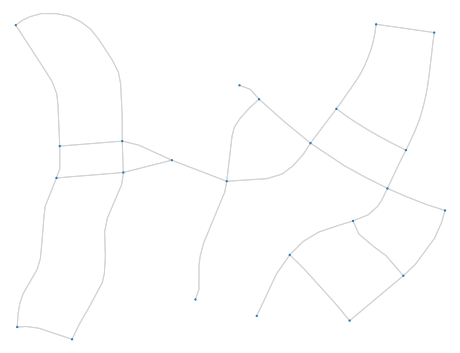

In [290]:

#Creating a bounding box
east, north, west, south = -78.814085,35.571632,-78.806876,35.576170  
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)


lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


In [287]:
pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1[1:-1]

In [291]:
-78.810579,35.571185,-78.806234,35.574300

(-78.810579, 35.571185, -78.806234, 35.5743)

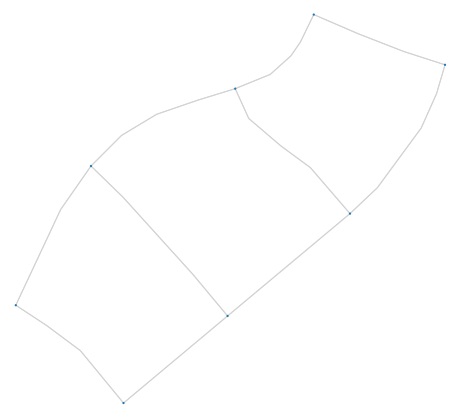

In [292]:

#Creating a bounding box
east, north, west, south = -78.810579,35.571185,-78.806234,35.574300  
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)


lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


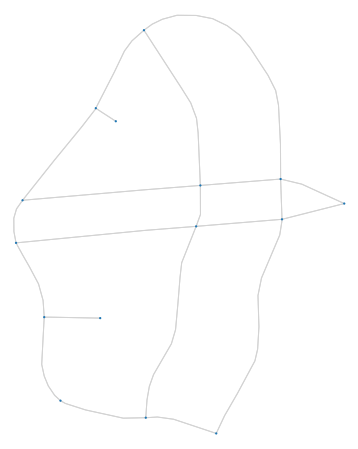

In [293]:

#Creating a bounding box
east, north, west, south = -78.815562,35.571590,-78.811184,35.576442  
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)


lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


In [295]:
mainroute3 = mainroute2+ pathlist

In [296]:
lines = node_list_to_path2(G, mainroute3)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
plot_path(lat2, long2, origin_point, destination_point)

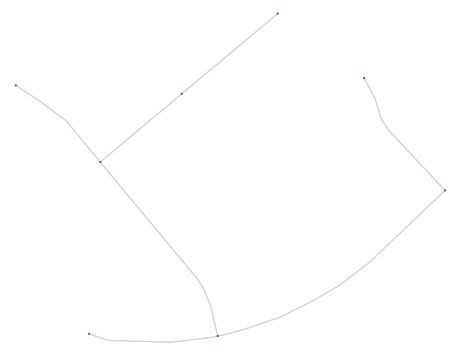

In [298]:

#Creating a bounding box
east, north, west, south = -78.810120,35.567422,-78.805056,35.572798  
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)


lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


In [299]:
mainroute3 = mainroute3+pathlist

In [300]:
lines = node_list_to_path2(G, mainroute3)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
plot_path(lat2, long2, origin_point, destination_point)

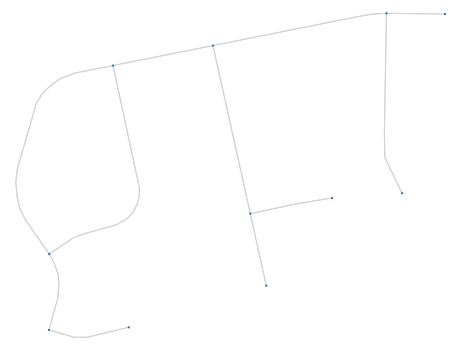

In [302]:

#Creating a bounding box
east, north, west, south = -78.809674,35.566876,-78.805060,35.569555  
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)


lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
    
    
def node_list_to_path2(G, node_list):
   
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    newlist=[]
    
    
    
    
    #for u, v in edge_nodes:
    #    if(G.get_edge_data(u, v)):
    #        newlist.append((u,v))
            
            
            
    for u, v in edge_nodes:
        if(G.get_edge_data(u, v)):
            newlist.append((u,v))
        else:    
            path1 = nx.shortest_path(G,u, v, weight='travel_time')
            path2 = list(zip(path1[:-1], path1[1:]))
            newlist = newlist+path2        
    #print(newlist)
    #print(len(newlist))
    
    for u, v in newlist:
        # if there are parallel edges, select the shortest in length
        
        data = min(G.get_edge_data(u, v).values(), 
                key=lambda x: x['length'])
            # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
            
    return lines    
    
    
    
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


pathlist = []
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
#pathlist1 = list(dict.fromkeys(pathlist))
#pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
lines = node_list_to_path2(G, pathlist)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
for i in pathlist:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data4['Latitude'] = lat1
data4['Longitude'] = long1
origin_point = (data4.loc[0]["Latitude"], data4.loc[0]["Longitude"]) 
destination_point = (data4.iloc[-1]["Latitude"], data4.iloc[-1]["Longitude"])
#plot_path(lat1, long1, origin_point, destination_point)


plot_path(lat2, long2, origin_point, destination_point)


In [303]:
mainroute3 = mainroute3+pathlist

In [304]:
lines = node_list_to_path2(G, mainroute3)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])
plot_path(lat2, long2, origin_point, destination_point)

In [305]:
-78.799709,35.568968,-78.791104,35.572267

(-78.799709, 35.568968, -78.791104, 35.572267)